In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ham10000-oversampled-128-128:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4431066%2F7629378%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240624%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240624T211614Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D71fcb735b537b0ec122d8e36695537f5596b514a62ab133c59249616e78f7c3e80729c11cb538f187068cbd1499fd65bf93d204cff9f35e1020e679aaf4a40f89a42c54d05b800a174fffc53c950609a8ea127b9cf4e91409ac68e241aee6a2e2448174f2d723c08140792a50114c6664e6808105ec8805bcb8351501ade9c269f8a415101347cb85f43c7659b1ae9abf3084721198857870f08ab8ae182639c3daceeb8ed9050389aad2bd8d9766d3093c59d54003a78522a2fdbe85d4ca24e6fcb1d17858cb28894e5e0b69abf93c8f8f5ed93216590aba243c9ae3342a56886066b5626c5e5a066990b5c346ec987310c1371df4e1f128c0bb3a3a244507c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 124748051 bytes downloaded
Downloaded and uncompressed: ham10000-oversampled-128-128
Data source import complete.


<h3>1. Defining functions</h3>
<ol style="margin-left: 20px; font-size: 16px;">
    <li>
        <p><strong>import_data()</strong></p>
        <p style="margin-left: 20px; font-size: 14px;">
        <ul>
            <li>Loads data into a TensorFlow dataset</li>
            <li>Defines a normalization layer</li>
            <li>Divides data into train, validation, and test data</li>
        </ul>
        </p>
    </li>
    <li>
        <p><strong>model_train()</strong></p>
        <p style="margin-left: 20px; font-size: 14px;">
        <ul>
            <li>Trains a model with the training and validation data
                </li>
            <li>Saves the model along with its training history</li>
        </ul>
        </p>
    </li>
    <li>
        <p><strong>model_evaluate()</strong></p>
        <p style="margin-left: 20px; font-size: 14px;">
        <ul style="margin-left: 20px; font-size: 14px;">
            <li>Shows training history</li>
            <li>Plots training accuracy and loss</li>
            <li>Evaluates the model on test data</li>
            <li>Shows a classification report</li>
            <li>Shows the confusion matrix</li>
        </ul>
        </p>
    </li>
</ol>


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Resizing, GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, InputLayer, RandomRotation, RandomFlip, RandomTranslation, RandomZoom, BatchNormalization, Rescaling, Dropout, Conv2D, MaxPool2D, Flatten, Normalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.efficientnet import EfficientNetB0

from imblearn.over_sampling import RandomOverSampler
import os
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
import shutil

def delete_directory(dirs):
    try:
      for dir in dirs:
        shutil.rmtree(dir)
        print(f"Directory deleted successfully.")
    except Exception as e:
        print(f"Error: {e}")

def import_data():
    Image_directory  = '/kaggle/input/ham10000-oversampled-128-128/'
    chunks = ['train_data','val_data','test_data']
    classes = {0:'MEL', 1:'NV', 2:'BCC', 3:'AKIEC', 4:'BKL', 5:'DF', 6:'VASC'}
    classes_num = np.array(list(classes.keys()))

    batch_size = 128

    train_data = image_dataset_from_directory(Image_directory + chunks[0], labels = "inferred", label_mode = "int",
          seed=123, shuffle = True, image_size=(128, 128), batch_size=batch_size)

    val_data = image_dataset_from_directory(Image_directory + chunks[1], labels = "inferred", label_mode = "int",
      seed=123, shuffle = True, image_size=(128, 128), batch_size=batch_size)

    test_data = image_dataset_from_directory(Image_directory + chunks[2], labels = "inferred", label_mode = "int",
          seed=123, shuffle = True, image_size=(128, 128), batch_size=batch_size)
\

    #Normalization layer for Basic CNN
    Normalization_layer = Normalization(axis = -1)
    train_image_data = train_data.map(lambda x , y: x)
    val_image_data = val_data.map(lambda x , y: x)
    data_0 = train_image_data.concatenate(val_image_data)

    Normalization_layer.adapt(data_0)

    return train_data, val_data, test_data, classes, Normalization_layer

def model_and_history_dir(model_name, runs = [0]):

    save_dir = '/kaggle/working/' + model_name

    history_dir = '/kaggle/working/history/'

    if not os.path.exists(history_dir):
        os.makedirs(history_dir)

    model_history_dir = []

    for run_n in runs:
      model_history_dir.append(history_dir + model_name + '_training_history' + '_'  + str(run_n) + '.csv' )

    return save_dir, model_history_dir

def restore_model(save_dir, model):
    if os.path.exists(save_dir):
      model = load_model(save_dir)
    return model

def model_train(data, n_epochs, model, lr = .001, run_n = [0], Normalize_bool = True, pt_model_w = None, tl_mode = 0, bn_train = False, bn_layer = None, pt_model_ftl_perc = None):

    train_data, val_data, test_data, classes, Normalization_layer = data
    image_size = (128,128)
    model_name = model[0]
    pt_model = model[1]

    model = Sequential ([Resizing(*image_size)])

    if Normalize_bool:
      model.add(Normalization_layer)

    model.add(RandomFlip("horizontal_and_vertical"))
    model.add(RandomRotation(0.2))
    model.add(RandomZoom(height_factor=(-0.1, 0.1)))

    if pt_model:

        pt_model = pt_model(include_top=False, weights = pt_model_w, input_shape = (*image_size,3))

        if tl_mode == 0:
            pt_model.trainable = False

        elif tl_mode == 1:
            pt_model.trainable = True
            fine_tune_at = .3 * len(pt_model.layers)
            if pt_model_ftl_perc:
                fine_tune_at = int(pt_model_ftl_perc * len(pt_model.layers))
            for layer in pt_model.layers[:fine_tune_at]:
                layer.trainable = False

        elif tl_mode == 2:
            pt_model.trainable = True

        if bn_layer:
          for layer in pt_model.layers[bn_layer:]:
            if isinstance(layer, BatchNormalization):
              layer.trainable = bn_train
        else:
          for layer in pt_model.layers:
            if isinstance(layer, BatchNormalization):
              layer.trainable = bn_train

        model.add(pt_model)

    else:

        for layer in [
            Conv2D(16, kernel_size = (3,3), input_shape = (*image_size, 3), activation = 'relu', padding = 'same'),
            Conv2D(32, kernel_size = (3,3), activation = 'relu'),
            MaxPool2D(pool_size = (2,2)),
            Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'),
            Conv2D(64, kernel_size = (3,3), activation = 'relu'),
            MaxPool2D(pool_size = (2,2), padding = 'same'),
        ]:
          model.add(layer)

    for layer in [GlobalAveragePooling2D(),
            Dense(2048, activation='relu'),
            Dense(1024, activation='relu'),
            Dense(7)]:
            model.add(layer)

    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5,
                                            min_lr=0.0001, cooldown=2)

    model.compile(optimizer=Adam(learning_rate = lr, amsgrad=True,),
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=[SparseCategoricalAccuracy(name='accuracy')]
              )


    save_dir, model_history_dir = model_and_history_dir(model_name, run_n)

    model_history_dir = model_history_dir[0]

    model = restore_model(save_dir, model)

    history = model.fit(train_data,
                        epochs=n_epochs,
                        validation_data=val_data,
                        callbacks=[learning_rate_reduction]
    )

    model.save(save_dir)

    pd.DataFrame(history.history).to_csv(model_history_dir, index=True)

def model_evaluate(data, model_name, runs = [0]):
    _, _, test_data, classes, _ = data

    checkpointdir, model_history_dir = model_and_history_dir(model_name, runs)

    model = load_model(checkpointdir)

    histories = []

    for history in runs:
      histories.append( pd.read_csv(model_history_dir[history]) )

    history = pd.concat(histories)
    history = history.reset_index(drop=True)

    test_images , test_labels = zip(*list(test_data.map(lambda x, y: (x, y))))
    test_images = np.concatenate(test_images)
    test_labels = np.concatenate(test_labels)

    #Showing training history
    history_show = history.sort_values(by=['accuracy'], ascending=False).drop(['Unnamed: 0'], axis = 1)
    print('Training history','\n', history_show.head(10),'\n')

    #Evaluating model on test data
    loss_test, acc_test = model.evaluate(test_data, verbose=1)
    print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))
    print('\n')

    #Classification report
    test_pred = np.argmax( model.predict(test_images), axis = 1)
    print('\n')
    print(classification_report(test_labels, np.around(test_pred, decimals=0)))

    #Plotting training accuracy and loss
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle(model_name + ' Performance', fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    ax1.plot(history['accuracy'], label='Train Accuracy')
    ax1.plot(history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, len(history), 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(history['loss'], label='Train Loss')
    ax2.plot(history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, len(history), 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

    #Confusion matrix
    confusion_mtx = cm =  confusion_matrix(test_labels, test_pred)
    plt.figure(figsize=(10,7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Test Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    print('\n')

data = import_data()

model_names = list({'Basic_CNN': None, 'EfficientNetB0': EfficientNetB0}.items())


Found 37506 files belonging to 7 classes.
Found 4725 files belonging to 7 classes.
Found 4704 files belonging to 7 classes.


<h3>2. Model Training and Evaluation</h3>

<h4 style="margin-left: 20px;"><li> EfficientNetB0</li></h3>

16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/10
332/332 [==============================] - 53s 104ms/step - loss: 0.8698 - accuracy: 0.6715 - val_loss: 0.9663 - val_accuracy: 0.6910 - lr: 0.0010
Epoch 2/10
332/332 [==============================] - 33s 98ms/step - loss: 0.6191 - accuracy: 0.7674 - val_loss: 0.8276 - val_accuracy: 0.7214 - lr: 0.0010
Epoch 3/10
332/332 [==============================] - 32s 95ms/step - loss: 0.5087 - accuracy: 0.8096 - val_loss: 0.6625 - val_accuracy: 0.7569 - lr: 0.0010
Epoch 4/10
332/332 [==============================] - 33s 98ms/step - loss: 0.4421 - accuracy: 0.8358 - val_loss: 0.6504 - val_accuracy: 0.7882 - lr: 0.0010
Epoch 5/10
332/332 [==============================] - 32s 94ms/step - loss: 0.3990 - accuracy: 0.8500 - val_loss: 0.7272 - val_accuracy: 0.7895 - lr: 0.0010
Epoch 6/10
332/332 [==============================] - 32s 96ms/step - loss: 0.3570 - accuracy: 0.8690 - val_loss: 0.6095 - val_accuracy: 0.8194 - lr:

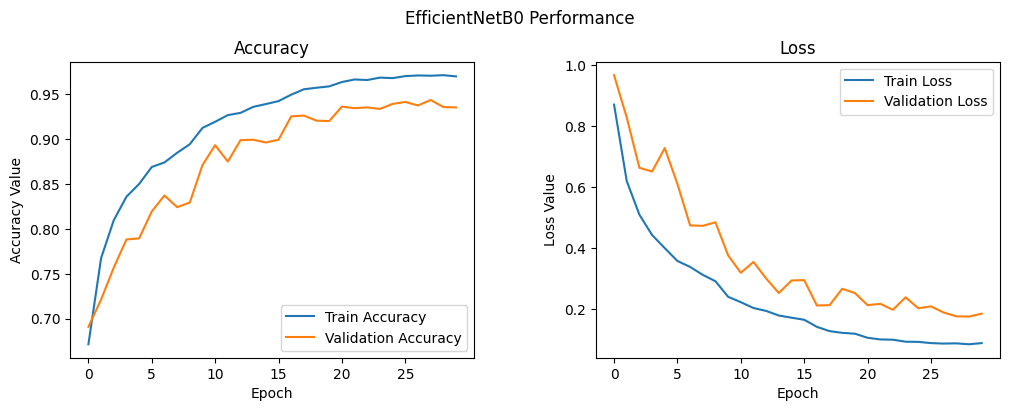

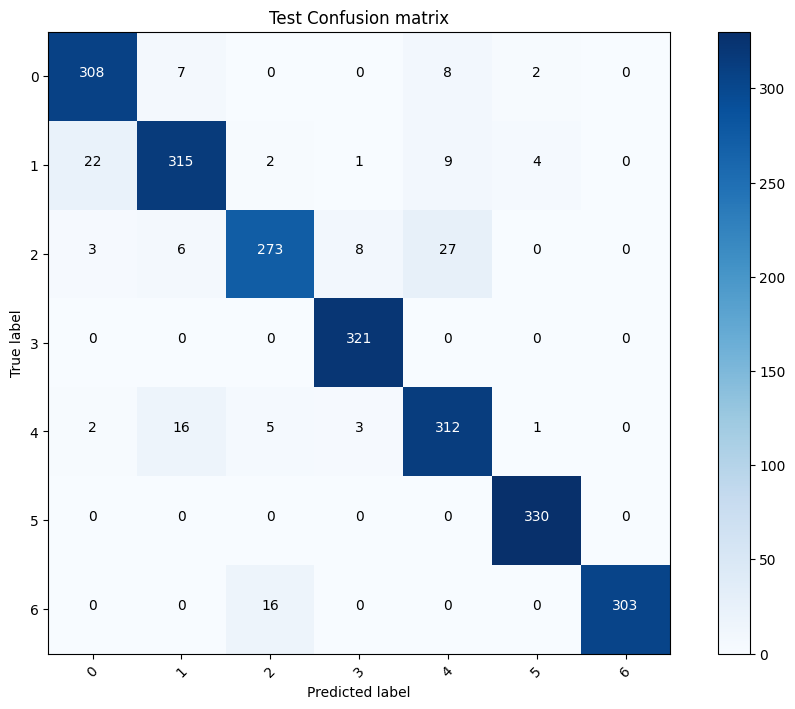

In [ ]:
model = model_names[1]

model_train(data, n_epochs = 10, model = model, lr = .001, run_n = [0], Normalize_bool = False, pt_model_w = 'imagenet', tl_mode = 0, bn_train = False, bn_layer = None)
model_train(data, n_epochs = 20, model = model, lr = .001, run_n = [1], Normalize_bool = False, pt_model_w = 'imagenet', tl_mode = 1, bn_train = False, pt_model_ftl_perc = .3)

model_evaluate(data, model[0], runs = [0, 1])

3 - Model Conversion

In [ ]:
import shutil
shutil.make_archive('model_output', 'zip', '/kaggle/working')


import tensorflow as tf
saved_model_dir = '/kaggle/working/EfficientNetB0'
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
delete_directory(model_and_history_dir(model[0],[0]))


Directory deleted successfully.
Error: lstat: path should be string, bytes or os.PathLike, not list
